# Setup and imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from pathlib import Path
from tqdm import tqdm
from csbdeep.utils import normalize
from utils import read_czi_image, fix_overlap, get_gpu_details
import tensorflow as tf

# Check available GPUs
# Check available GPUs and print details
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    get_gpu_details()
else:
    print("No GPU found. Using CPU instead.")

Device name: /device:GPU:0
Device type: GPU
GPU model: device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


# Input image and ground truth label loaders 

In [2]:
# Define the directories containing your training/validation images and annotated ground truth pairs
img_directory = Path("./train_validation_data/train_data")
label_directory = Path("./train_validation_data/ground_truth_labels")

In [3]:
# Create a list containing all file paths to both .czi input images and .tiff ground truth labels
f_masks = sorted(label_directory.glob("*.tiff"))
f_images = sorted(img_directory.glob("*.czi"))

print(f'Found {len(f_images)} images and {len(f_masks)} annotations')

Found 6 images and 18 annotations


In [4]:
# Read each .czi stack, select channels used for training, reshape it into channels-last format and apply percentile-based normalization

# Select channels used for training (0 - Lgr5-GFP, 1 - DAPI, 2 - B-catenin and 3 - LSD1 )
channels=(0,1,2,3)

# Name your model (include info on epochs you plan to use and channel info)
model_name = 'model_gfp_dapi_bcat_lsd1_epoch_100'
epochs = int(model_name.split("_")[-1])

# Initialize an empty list to hold the normalized images
normalized_images = []

# Iterate over each .czi stack contained in f_images
for filepath in tqdm(f_images):

    # Read the image from file and reshape it into channels-last format
    image = read_czi_image(filepath, channels=channels)

    # Normalize the read image along axes 0 and 1 (X and Y)
    normalized_image = normalize(image, axis=(0,1))

    # Append the normalize image to the list
    normalized_images.append(normalized_image)

# Convert the list into a tuple (this is intended to be an immutable fixed set of images)
imgs = tuple(normalized_images)

# A more concise way to perform the same process using list comprehensions
# imgs = tuple(normalize(read_czi_image(filepath), axis=(0,1)) for filepath in tqdm(f_images))

100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


In [5]:
# Ground truth label loader (ome.tiff files)
raw_masks = tuple(tifffile.imread(filepath) for filepath in tqdm(f_masks))

100%|██████████| 18/18 [00:00<00:00, 40.30it/s]


# Removing overlapping pixels in between class annotations

In [6]:
masks, bh_shared, bt_shared, ht_shared = fix_overlap(raw_masks, f_masks)
del raw_masks # Remove raw_masks variable to free up memory    


Fixing overlap results: 

1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (6561, 7479, 3) 


Fixing overlap results: 

1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (9315, 9288, 3) 


Fixing overlap results: 

1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (8424, 9342, 3) 


Fixing overlap results: 

1837I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share pixels: False
Background and Tumor share pixels: False
Healthy and Tumor share pixels: False
Output mask array: (8424, 8397, 3) 


Fixing overlap results: 

1849I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ

Background and Healthy share 

In [7]:
# Checking how many pixels overlaped in between classes (bh_shared, bt_shared, ht_shared)
for i, array in enumerate(ht_shared):
    print(f"Array {i}")
    unique_values, value_counts = np.unique(array, return_counts=True)
    # Print the unique values and their counts
    for value, count in zip(unique_values, value_counts):
        print(f"Value: {value}, Count: {count}")

Array 0
Value: 0, Count: 49069719
Array 1
Value: 0, Count: 86516785
Value: 255, Count: 935
Array 2
Value: 0, Count: 78695868
Value: 255, Count: 1140
Array 3
Value: 0, Count: 70735627
Value: 255, Count: 701
Array 4
Value: 0, Count: 31741956
Array 5
Value: 0, Count: 49271652


# Visualize annotations

In [8]:
# # Plot an example image and all of its segmentation masks
# i = 3 #Define the position of the sample in the array

# graph_title = ["Background", "Healthy", "Tumor"]

# for mask_nr in range(3):
#     fig, (a0,a1) = plt.subplots(1,2,figsize=(15,5))
#     a0.imshow(imgs[i][::4,::4]); #plot every 4th pixel (subsampling)
#     a0.set_title('Input image')
#     a1.imshow(masks[i][::4,::4,mask_nr], cmap='gray'); #plot every 4th pixel (subsampling)                    
#     a1.set_title(f"{graph_title[mask_nr]} Label")
#     fig.suptitle(f_images[i].name)
#     # plt.savefig(fname=f"prediction_tiffs/{f_images[i].name}.{graph_title[mask_nr]}.png", dpi=300, format='png')
#     None;

# Train and validation dataset definition

In [9]:
# Using list slicing to leave 2 validation images one with and one without tumors (at index 3 and 5)
# By specifying dtype=object np allows for the creation of an ndarray that can store arrays with different shapes
imgs_array = np.asarray(imgs, dtype=object)
masks_array = np.asarray(masks, dtype=object)
train_index = [0, 1, 2, 4]
val_index = [3, 5]

X = tuple(imgs_array[train_index]) # Training inputs (features)
Y = list(masks_array[train_index]) # Training labels (target)

Xv = tuple(imgs_array[val_index]) # Validation inputs (features)
Yv = list(masks_array[val_index]) # Validation labels (target)

print(f"X: {len(X)}, Y: {len(Y)}, Xv: {len(Xv)}, Yv: {len(Yv)}")

X: 4, Y: 4, Xv: 2, Yv: 2


# Model (U-net) training

In [10]:
import model as M

In [11]:
n_dim=2

conf = M.UNetConfig(n_dim=n_dim,
                  n_channel_in = len(channels),
                  n_channel_out = 3,
                  patch_size=(512,512),
                  train_batch_size=4,
                  train_class_weight = (1,1,1))

In [12]:
vars(conf)

{'n_dim': 2,
 'axes': 'XYC',
 'n_channel_in': 4,
 'n_channel_out': 3,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'softmax',
 'unet_input_shape': (None, None, 4),
 'train_loss': 'categorical_crossentropy',
 'train_epochs': 100,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0},
 'train_class_weight': (1, 1, 1),
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'patch_size': (512, 512)}

In [13]:
model = M.UNet(conf, model_name, basedir='models')

In [14]:
model.train(X, Y, Xv, Yv, epochs=epochs, steps_per_epoch=16)

Epoch 1/100
16/16 [==============================] - 13s 115ms/step - loss: 0.9071 - metric_precision: 0.3875 - metric_recall: 0.1454 - metric_f1: 0.2009 - val_loss: 0.4655 - val_metric_precision: 0.8696 - val_metric_recall: 0.8599 - val_metric_f1: 0.8647 - lr: 4.0000e-04
Epoch 2/100
16/16 [==============================] - 1s 58ms/step - loss: 0.3563 - metric_precision: 0.8105 - metric_recall: 0.8543 - metric_f1: 0.8314 - val_loss: 0.2112 - val_metric_precision: 0.8605 - val_metric_recall: 0.9292 - val_metric_f1: 0.8935 - lr: 4.0000e-04
Epoch 3/100
16/16 [==============================] - 1s 60ms/step - loss: 0.1798 - metric_precision: 0.8605 - metric_recall: 0.8970 - metric_f1: 0.8779 - val_loss: 0.2936 - val_metric_precision: 0.8462 - val_metric_recall: 0.8922 - val_metric_f1: 0.8686 - lr: 4.0000e-04
Epoch 4/100
16/16 [==============================] - 1s 57ms/step - loss: 0.1825 - metric_precision: 0.8936 - metric_recall: 0.9006 - metric_f1: 0.8963 - val_loss: 0.1853 - val_metric_p

# Apply the model on test images

In [15]:
test_img_directory = Path("test_data")
f_test_images = sorted(test_img_directory.glob("*.czi"))
print(f'found {len(f_test_images)} test images')

test_imgs = tuple(normalize(read_czi_image(f, channels=channels), axis=(0,1)) for f in tqdm(f_test_images))

found 6 test images


100%|██████████| 6/6 [00:22<00:00,  3.79s/it]


In [16]:
model

UNet(model_gfp_dapi_bcat_lsd1_epoch_100): XYC → XYC
├─ Directory: C:\Users\adiez_cmic\github_repos\UNet_SemSeg_healthy_tumor_SRs\models\model_gfp_dapi_bcat_lsd1_epoch_100
└─ UNetConfig(n_dim=2, axes='XYC', n_channel_in=4, n_channel_out=3, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=False, unet_n_depth=2, unet_kern_size=3, unet_n_first=32, unet_last_activation='softmax', unet_input_shape=(None, None, 4), train_loss='categorical_crossentropy', train_epochs=100, train_steps_per_epoch=400, train_learning_rate=0.0004, train_batch_size=4, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0, 'verbose': True}, train_class_weight=(1, 1, 1), unet_batch_norm=False, unet_dropout=0.0, patch_size=(512, 512))

In [17]:
predictions = []
for img in test_imgs:
    prediction = model.predict(img, axes='XYC', n_tiles=(8,8,1))
    predictions.append(prediction)
    print(prediction.shape)

c:\Users\adiez_cmic\miniforge3\envs\EMBL_tensorflow\lib\site-packages\csbdeep\models\base_model.py:311: UserWarning: skipping normalization step after prediction because number of input and output channels differ.
  warnings.warn('skipping normalization step after prediction because ' +
100%|██████████| 64/64 [00:03<00:00, 17.54it/s]


(7479, 7479, 3)


100%|██████████| 64/64 [00:03<00:00, 18.90it/s]


(5670, 8397, 3)


100%|██████████| 64/64 [00:03<00:00, 17.54it/s]


(7506, 7506, 3)


100%|██████████| 64/64 [00:02<00:00, 22.36it/s]


(6561, 5616, 3)


100%|██████████| 64/64 [00:03<00:00, 18.77it/s]


(6588, 7479, 3)


100%|██████████| 64/64 [00:03<00:00, 20.51it/s]

(6561, 6561, 3)


In [18]:
len(predictions)

6

0it [00:00, ?it/s]

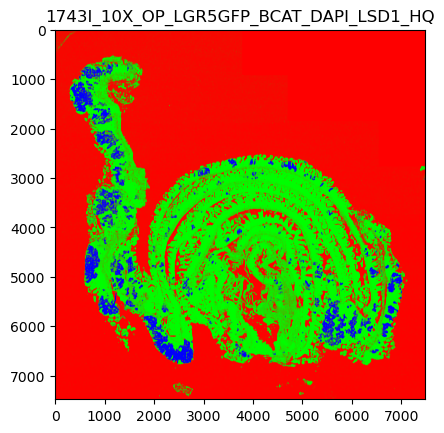

1it [00:02,  2.47s/it]

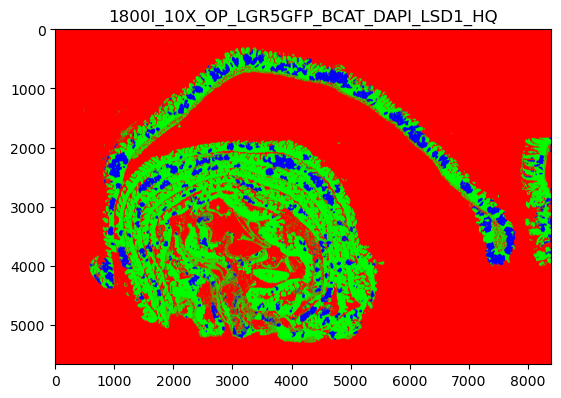

2it [00:04,  2.34s/it]

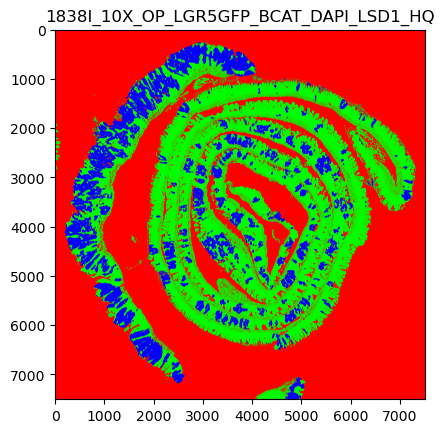

3it [00:07,  2.33s/it]

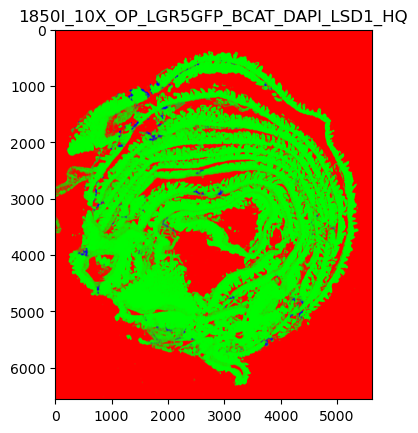

4it [00:08,  2.07s/it]

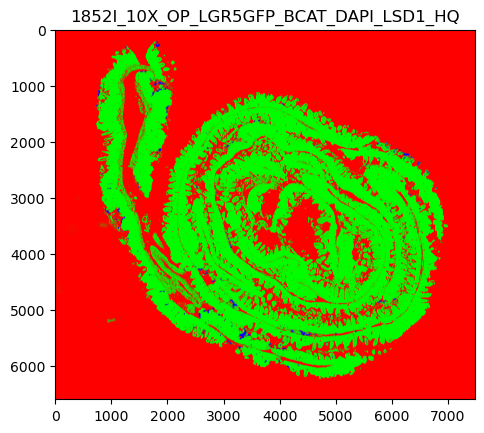

5it [00:11,  2.16s/it]

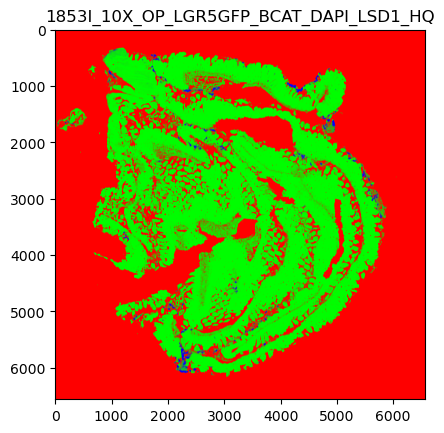

6it [00:13,  2.18s/it]


In [19]:
for i, img in tqdm(enumerate(predictions)):
    plt.imshow(img)
    plt.title(f_test_images[i].stem)
    plt.show()